# Explore mcmc results and create dataframes of parameters and ccn results.

In [297]:

from models import CCNmodel_m1
from config import get_Extra, load_data
import pints
import pints.io
import pints.plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import matplotlib.gridspec as gridspec
from scipy.stats import skew
from scipy.stats import mode
import seaborn as sns

In [113]:
# make trace plots:
def trace_plot(plt_samples, burn_in, initial_guess, param_name):
    f,axs = pints.plot.trace(plt_samples[:, :, :], parameter_names=[param_name])
    f.set_figheight(5)
    axs[0][0].axvline(x=plt_samples[:, burn_in:, :].mean(), color='r', linestyle='--', label='mcmc mean '+str(np.round(plt_samples[:, burn_in:, :].mean(),3)))
    axs[0][0].axvline(x=np.median(plt_samples[:, burn_in:, :]), color='r', label='mcmc median '+str(np.round(np.median(plt_samples[:, burn_in:, :]),3)))
    axs[0][0].axvline(x=mode(plt_samples[:, burn_in:, :],axis=None)[0], linestyle=':', color='r', label='mcmc mode '+str(np.round(mode(plt_samples[:, burn_in:, :],axis=None)[0],3)))
    axs[0][0].axvline(x=initial_guess, color='b', linestyle='--', label='initial guess')
    axs[0][0].legend()
    axs[0][1].axvline(x=burn_in, color='grey', linestyle='--')

## Example analysis of one time-step (trace plots and marginal pdfs):

In [120]:
# window idx for example:
idx = 20

#set number of discarded iterations:
burn_in = 20000

#get chains for that window:
chains = sorted(glob.glob('../chains/mcmc_30k*5chains_'+str(idx)+'_*.csv'))
chains

['../chains/mcmc_30k_m1_5chains_5chains_20_0.csv',
 '../chains/mcmc_30k_m1_5chains_5chains_20_1.csv',
 '../chains/mcmc_30k_m1_5chains_5chains_20_2.csv',
 '../chains/mcmc_30k_m1_5chains_5chains_20_3.csv',
 '../chains/mcmc_30k_m1_5chains_5chains_20_4.csv']

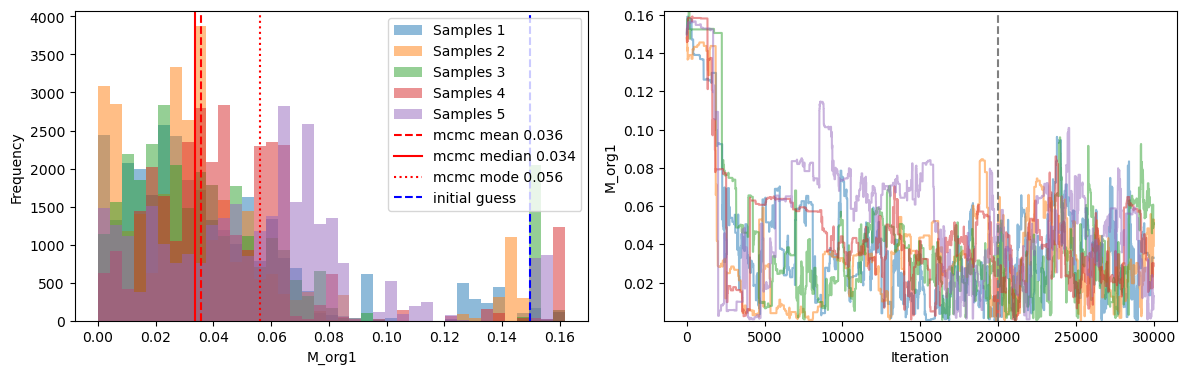

In [121]:
# load data:
M_org1_chains = pints.io.load_samples(chains[0])
D1_chains = pints.io.load_samples(chains[1])
N1_chains = pints.io.load_samples(chains[2])
D2_chains = pints.io.load_samples(chains[3])
N2_chains = pints.io.load_samples(chains[4])

#get initial guesses for parameters:
bimodal_params = pd.read_csv('../input_data/bimodal_params_windows.csv')
M_org1_initial = pd.read_csv('../input_data/M_org1_initialguess.csv')

trace_plot(np.expand_dims(M_org1_chains, axis=2), burn_in, M_org1_initial['M_org1'][20], 'M_org1')

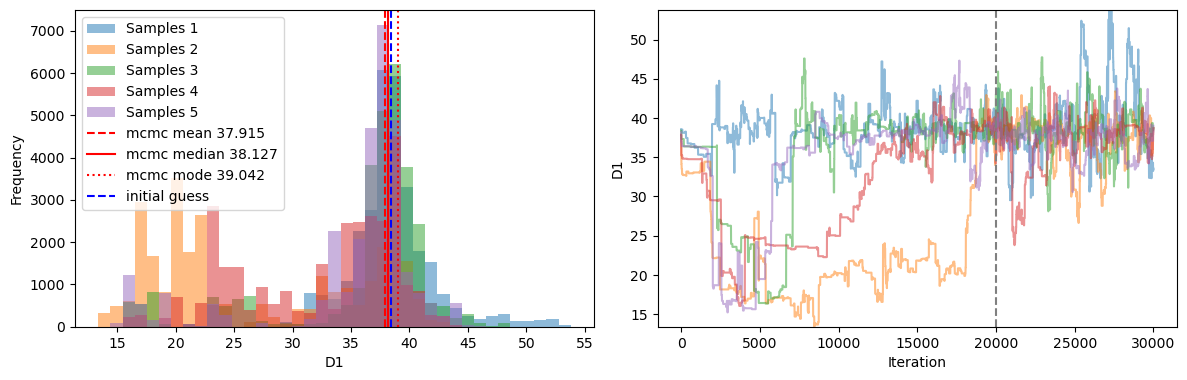

In [122]:
trace_plot(np.expand_dims(D1_chains, axis=2), burn_in, bimodal_params['mode1_d'][20], 'D1')

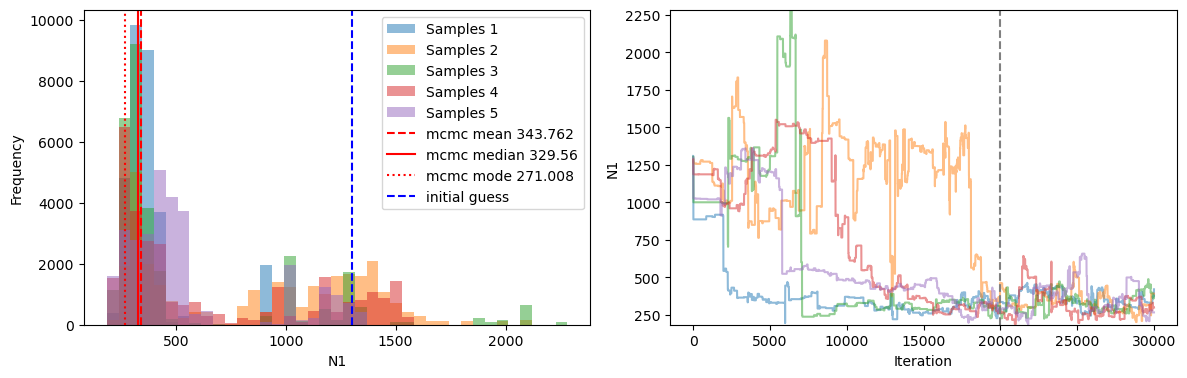

In [123]:
trace_plot(np.expand_dims(N1_chains, axis=2), burn_in, bimodal_params['NSD1_sum'][20], 'N1')

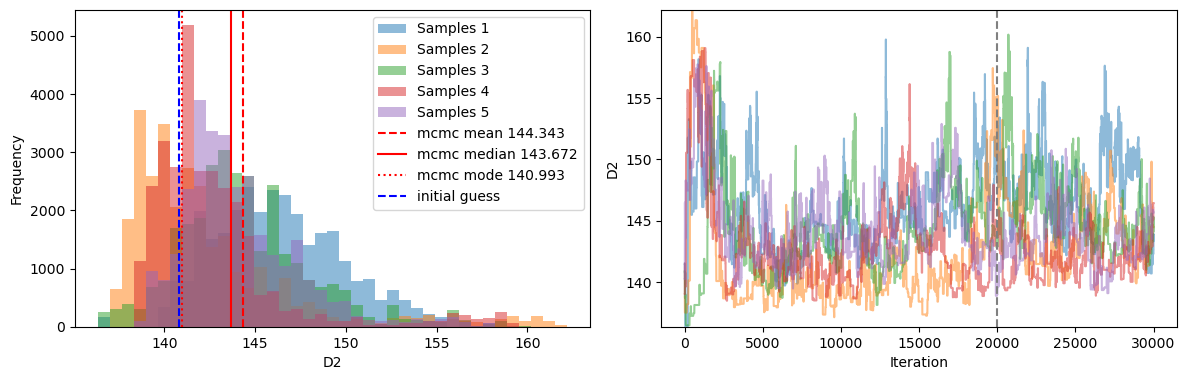

In [124]:
trace_plot(np.expand_dims(D2_chains, axis=2), burn_in, bimodal_params['mode2_d'][20], 'D2')

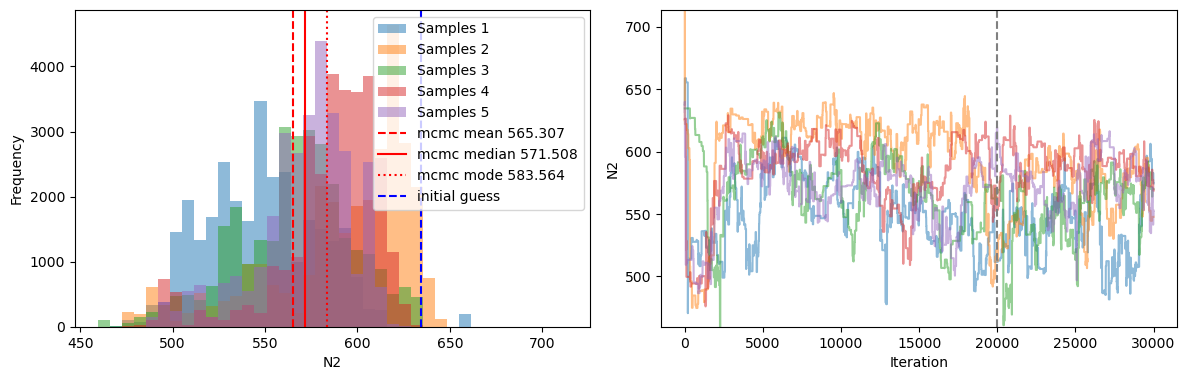

In [125]:
trace_plot(np.expand_dims(N2_chains, axis=2), burn_in, bimodal_params['NSD2_sum'][20], 'N2')

In [119]:
# print rhat statistics:
cut_off = 0.75
print('M_org1 rhat:', pints.rhat(M_org1_chains, cut_off), 
      'D1 rhat:', pints.rhat(D1_chains, cut_off),
      'N1 rhat:', pints.rhat(N1_chains, cut_off),
      'D2 rhat:', pints.rhat(D2_chains, cut_off),
      'N2 rhat:', pints.rhat(N2_chains, cut_off))

# print ess statistics:
#samples = np.column_stack([M_org1_chains[:,burn_in:].reshape(-1), D1_chains[:,burn_in:].reshape(-1), N1_chains[:,burn_in:].reshape(-1), D2_chains[:,burn_in:].reshape(-1), N2_chains[:,burn_in:].reshape(-1)])
#print('total ess:', pints.effective_sample_size(samples))

M_org1 rhat: 1.09919987408703 D1 rhat: 1.0902297368704212 N1 rhat: 1.17588139954497 D2 rhat: 1.3575583642822209 N2 rhat: 1.4240459442704223


(<Figure size 1500x1500 with 25 Axes>,
 array([[<Axes: ylabel='Frequency'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: ylabel='D1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='N1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='D2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: xlabel='M_org1', ylabel='N2'>, <Axes: xlabel='D1'>,
         <Axes: xlabel='N1'>, <Axes: xlabel='D2'>, <Axes: xlabel='N2'>]],
       dtype=object))

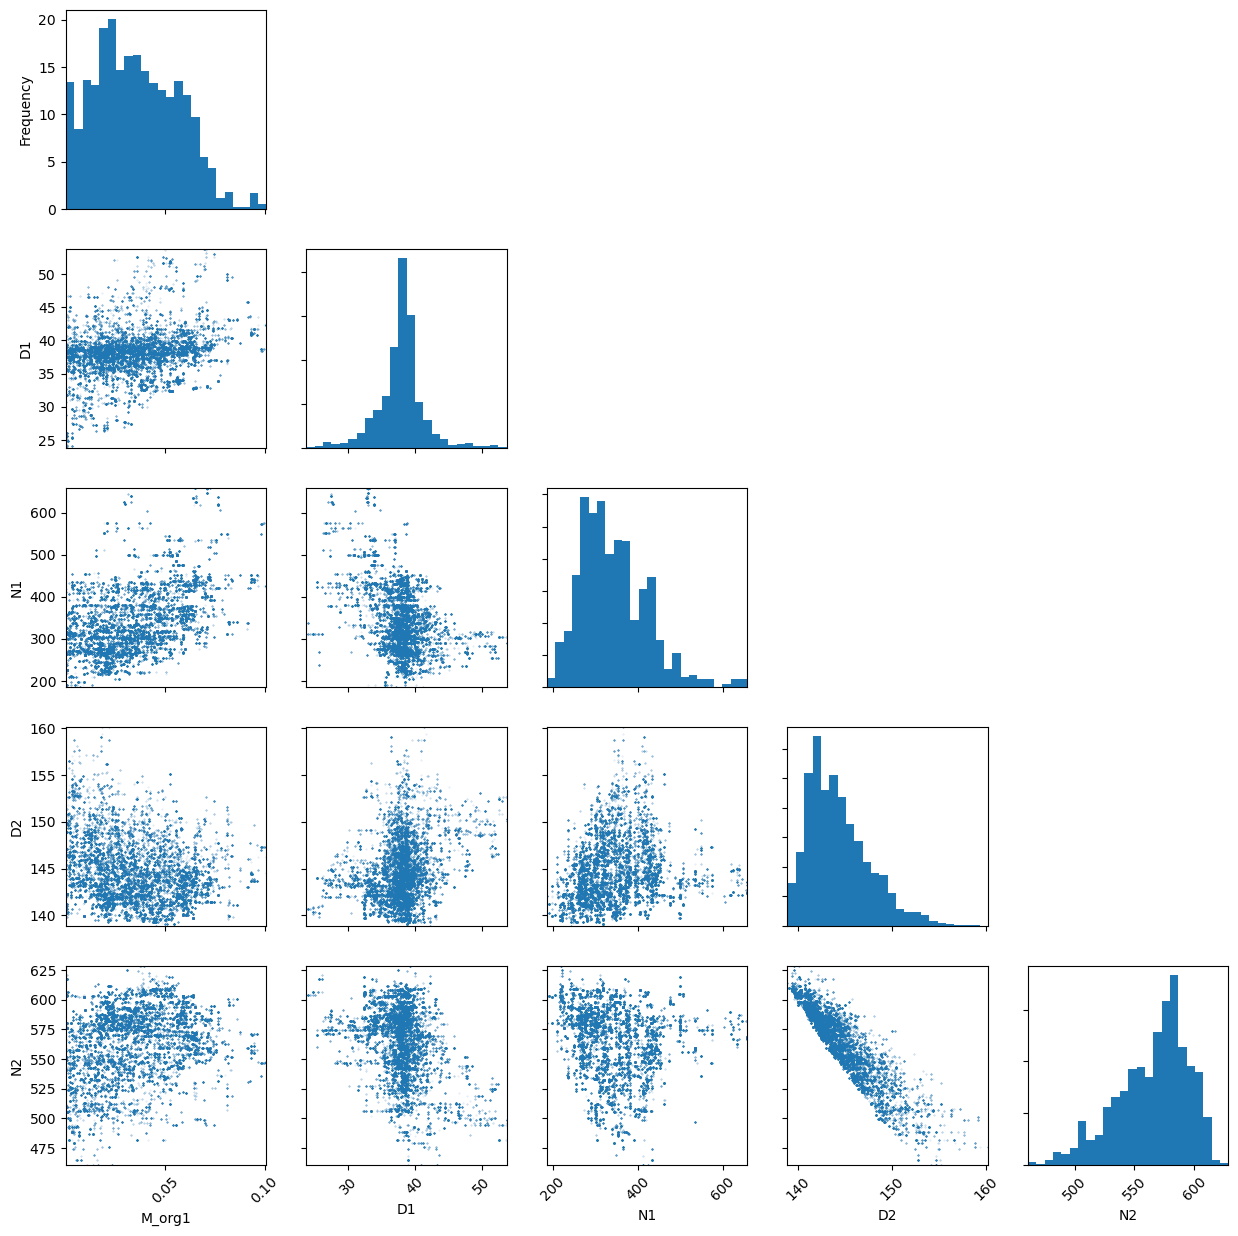

In [126]:
samples = np.stack([M_org1_chains[:,burn_in:], D1_chains[:,burn_in:], N1_chains[:,burn_in:], D2_chains[:,burn_in:], N2_chains[:,burn_in:]], axis=2)
pints.plot.pairwise(np.vstack(samples), kde=False, parameter_names=['M_org1', 'D1', 'N1', 'D2', 'N2'])

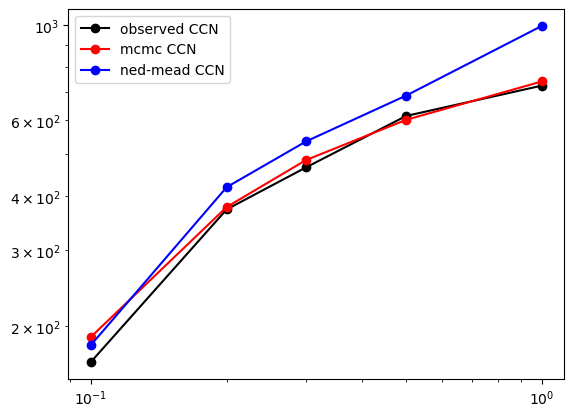

In [140]:
# compare CCN spectra:

# setup model:
Extra = get_Extra(idx)
model_data, initial_guesses, prior_params, response = load_data(idx)
m = CCNmodel_m1(Extra, model_data, return_all=True)

test_model_output = m(np.mean(samples, axis=(0,1)))

ss = [0.1,0.2,0.3,0.5,1.0]

nedmead_results = pd.read_csv('../result_nedler_mead_org0p12.csv')
nedmed_ccn = np.fromstring(nedmead_results['Predicted_CCN'][idx].strip('[]'), sep=' ') 

plt.loglog(ss, response, label='observed CCN', color='k', marker='o')
plt.loglog(ss, test_model_output[0]+test_model_output[1], label='mcmc CCN', color='r', marker='o')
plt.loglog(ss, nedmed_ccn, label='ned-mead CCN', color='b', marker='o')
plt.legend()

## Main data processing (create parameter dataframe and CCN results dataframe):

To get parameter values and statistics, run summarize_mcmc_posteriors.py

In [193]:
# load mcmc parameters for summary statistics and calculate CCN results:
mcmc_params = pd.read_csv('../summary_30k_5chains.csv')

mcmc_results = pd.DataFrame({'datetime': mcmc_params['datetime']})

cols_to_add = [
    'NRMSE', 'predicted_CCN1', 'predicted_CCN2', 'inorg_density', 'Predicted_CCN',
    'f_org1', 'f_AS1', 'f_BC1', 'f_org2', 'f_AS2', 'f_BC2',
    'k1', 'k2', 'mass_aitken', 'mass_accumulation'
]

for col in cols_to_add:
    if col in ['predicted_CCN1', 'predicted_CCN2', 'Predicted_CCN']:
        mcmc_results[col] = pd.Series([np.nan]*len(mcmc_results), dtype='object')
    else:
        mcmc_results[col] = np.nan

check_rows = []

for ii in range(len(mcmc_params)):

    # skip rows with NaN:
    if pd.isna(mcmc_params.iloc[ii]).any():
        all_cols_to_nan = mcmc_results.columns.difference(['datetime'])
        mcmc_results.loc[ii, all_cols_to_nan] = np.nan

    else:
        try:
            Extra = get_Extra(ii)
            model_data, initial_guesses, prior_params, response = load_data(ii)
            m = CCNmodel_m1(Extra, model_data, return_all=True)

            model_parameters = [mcmc_params.iloc[ii]['M_org1_median'], mcmc_params.iloc[ii]['D1_median'], mcmc_params.iloc[ii]['N1_median'], mcmc_params.iloc[ii]['D2_median'], mcmc_params.iloc[ii]['N2_median']]
            ccn1, ccn2, k1, k2, k_inorg1, k_inorg2, mass_frac_aitken, mass_frac_accumulation, total_ait_mass, total_acc_mass, total_mass,info_mass, NSD1_vec, NSD2_vec = m(model_parameters)

            nrmse = np.sqrt(np.mean((response - (ccn1+ccn2))**2)) / np.mean(response)

            mcmc_results.at[ii, 'NRMSE'] = nrmse
            mcmc_results.at[ii, 'predicted_CCN1'] = ccn1
            mcmc_results.at[ii, 'predicted_CCN2'] = ccn2
            mcmc_results.at[ii, 'inorg_density'] = Extra['rho_inorg']
            mcmc_results.at[ii, 'Predicted_CCN'] = ccn1 + ccn2
            mcmc_results.at[ii, 'f_org1'] = mass_frac_aitken[0]
            mcmc_results.at[ii, 'f_AS1'] = mass_frac_aitken[2]
            mcmc_results.at[ii, 'f_BC1'] = mass_frac_aitken[4]
            mcmc_results.at[ii, 'f_org2'] = mass_frac_accumulation[0]
            mcmc_results.at[ii, 'f_AS2'] = mass_frac_accumulation[2]
            mcmc_results.at[ii, 'f_BC2'] = mass_frac_accumulation[4]
            mcmc_results.at[ii, 'k1'] = k1
            mcmc_results.at[ii, 'k2'] = k2
            mcmc_results.at[ii, 'mass_aitken'] = total_ait_mass
            mcmc_results.at[ii, 'mass_accumulation'] = total_acc_mass

        except Exception as e:
            print(f"No model output for mean parameters for row {ii}: {e}")
            mcmc_results.loc[ii, all_cols_to_nan] = np.nan
            check_rows.append(ii)
            continue

mcmc_results.to_csv('../30k_5chains_medianparams_ccn_results.csv')

No model output for mean parameters for row 32: cannot unpack non-iterable NoneType object
No model output for mean parameters for row 40: cannot unpack non-iterable NoneType object
No model output for mean parameters for row 51: cannot unpack non-iterable NoneType object
No model output for mean parameters for row 79: cannot unpack non-iterable NoneType object
No model output for mean parameters for row 100: cannot unpack non-iterable NoneType object
No model output for mean parameters for row 104: cannot unpack non-iterable NoneType object
No model output for mean parameters for row 111: cannot unpack non-iterable NoneType object
No model output for mean parameters for row 115: cannot unpack non-iterable NoneType object
No model output for mean parameters for row 117: cannot unpack non-iterable NoneType object
No model output for mean parameters for row 123: cannot unpack non-iterable NoneType object
No model output for mean parameters for row 136: cannot unpack non-iterable NoneType

In [159]:
# how many time-steps show convergence:
rhat_thresh = 1.2
num_conv = mcmc_params.where(mcmc_params['M_org1_rhat'] < rhat_thresh).where(mcmc_params['D1_rhat'] < rhat_thresh).where(mcmc_params['N1_rhat'] < rhat_thresh).where(mcmc_params['D2_rhat'] < rhat_thresh).where(mcmc_params['N2_rhat'] < rhat_thresh).dropna()

print(f"Number of time-steps showing convergence (rhat < {rhat_thresh}): {num_conv.shape[0]} out of {len(mcmc_params)}")

Number of time-steps showing convergence (rhat < 1.2): 799 out of 6580


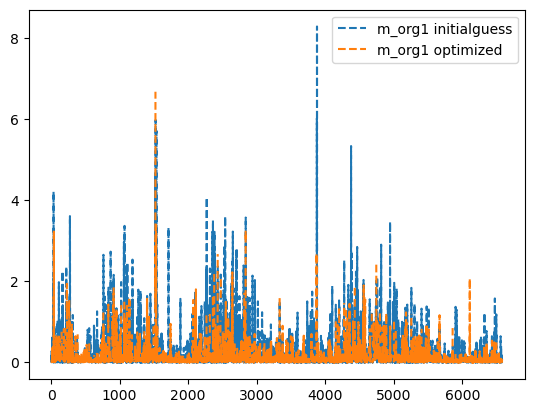

In [158]:
m_org1_guess = pd.read_csv('../input_data/M_org1_initialguess.csv')

plt.plot(m_org1_guess, label='m_org1 initialguess', linestyle='--')
plt.plot(mcmc_params['M_org1_mean'], label='m_org1 optimized', linestyle='--')
plt.legend()

In [ ]:
# add seaon to mcmc_results:
def get_season(date):
    if date.month in [3, 4, 5]:
        return 0
    elif date.month in [6, 7, 8]:
        return 1
    elif date.month in [9, 10, 11]:
        return 2
    else:
        return 3
    

observed_results = pd.read_csv('../input_data/CCN.csv')
sc_cols = ['SC1', 'SC2', 'SC3', 'SC4', 'SC5']
observed_results['CCN'] = observed_results[sc_cols].values.tolist()

nedmead_results['Predicted_CCN'] = nedmead_results['Predicted_CCN'].apply(
    lambda x: np.fromstring(x.strip('[]'), sep=' ') if isinstance(x, str) else np.nan
)

# Helper to compute seasonal stats
def compute_seasonal_stats(df, column_name, label):
    seasonal_stats = []

    for season, group in df.groupby('season'):
        valid_rows = group[column_name].dropna()
        arrays = [np.array(row) for row in valid_rows if isinstance(row, (list, np.ndarray))]

        if arrays:
            stacked = np.vstack(arrays)
            seasonal_stats.append({
                'season': season,
                'source': label,
                'median': np.median(stacked, axis=0),
                'p25': np.percentile(stacked, 25, axis=0),
                'p75': np.percentile(stacked, 75, axis=0)
            })
        else:
            seasonal_stats.append({
                'season': season,
                'source': label,
                'median': np.nan,
                'p25': np.nan,
                'p75': np.nan
            })

    return pd.DataFrame(seasonal_stats)

# Apply to all three datasets
mcmc_results['season'] = pd.to_datetime(mcmc_results['datetime']).apply(get_season)
nedmead_results['season'] = pd.to_datetime(nedmead_results['datetime']).apply(get_season)
observed_results['season'] = pd.to_datetime(observed_results['datetime']).apply(get_season)

seasonal_stats_mcmc = compute_seasonal_stats(mcmc_results, 'Predicted_CCN', 'mcmc')
seasonal_stats_nedmead = compute_seasonal_stats(nedmead_results, 'Predicted_CCN', 'nedmead')
seasonal_stats_obs = compute_seasonal_stats(observed_results, 'CCN', 'observed')

# Combine all into one DataFrame
seasonal_stats_all = pd.concat([seasonal_stats_mcmc, seasonal_stats_nedmead, seasonal_stats_obs], ignore_index=True)


"# Calculate asymmetric error bars\nyerr_lower = median - p25\nyerr_upper = p75 - median\nyerr = np.vstack([yerr_lower, yerr_upper])  # shape (2, N)\n\n# Plot\nplt.figure()\nplt.errorbar(x, median, yerr=yerr, fmt='o', label='Median ± IQR')\nplt.xscale('log')\nplt.yscale('log')\n\naxes[0].loglog(ss, seasonal_stats_all.loc[(seasonal_stats_all['season'] == 0) & (seasonal_stats_all['source'] == 'observed')]['median'].iloc[0], label='observed CCN', color='k', marker='o')\naxes[0].loglog(ss, seasonal_stats_all.loc[(seasonal_stats_all['season'] == 0) & (seasonal_stats_all['source'] == 'mcmc')]['median'].iloc[0], label='mcmc CCN', color='r', marker='o')\naxes[0].loglog(ss, seasonal_stats_all.loc[(seasonal_stats_all['season'] == 0) & (seasonal_stats_all['source'] == 'nedmead')]['median'].iloc[0], label='ned-mead CCN', color='b', marker='o')\naxes[0].set_title('Spring')\naxes[0].legend()\n"

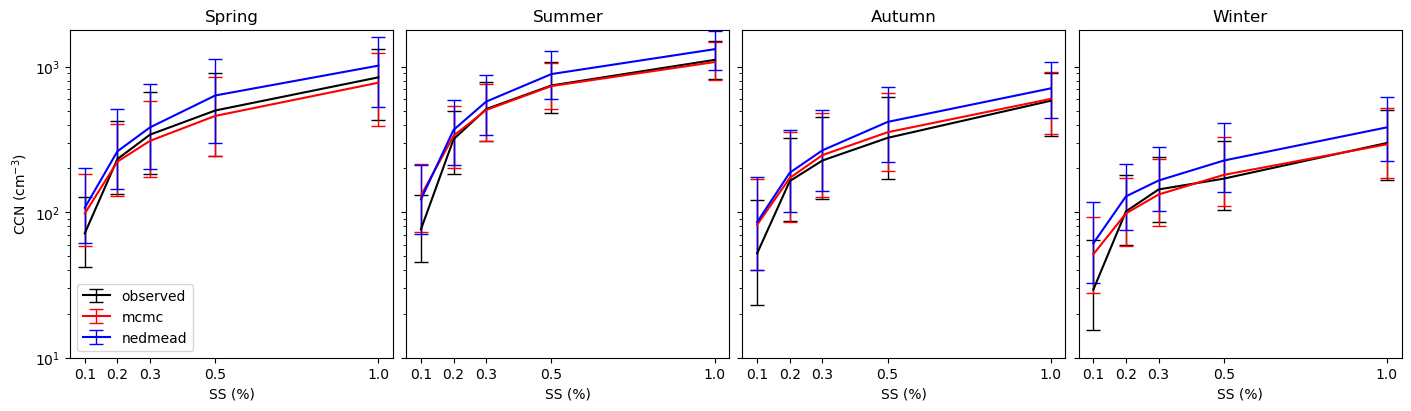

In [ ]:
# plot CCN for each season:

fig,axes = plt.subplots(ncols=4, nrows=1, figsize=(14,4), sharey=True, constrained_layout=True)
ss = [0.1,0.2,0.3,0.5,1.0]

for i in range(4):
    for j, source in enumerate(['observed', 'mcmc', 'nedmead']):
        seasonal_data = seasonal_stats_all.loc[
            (seasonal_stats_all['season'] == i) & (seasonal_stats_all['source'] == source)
        ]
        
        if not seasonal_data.empty:
            median = seasonal_data['median'].iloc[0]
            p25 = seasonal_data['p25'].iloc[0]
            p75 = seasonal_data['p75'].iloc[0]

            # Calculate asymmetric error bars
            yerr_lower = median - p25
            yerr_upper = p75 - median
            yerr = np.vstack([yerr_lower, yerr_upper])  # shape (2, N)

            axes[i].errorbar(ss, median, yerr=yerr, label=source, color=['k', 'r', 'b'][j], capsize=5, elinewidth=1, markeredgewidth=1)
            #axes[i].set_xscale('log')
            axes[i].set_yscale('log')
            axes[i].set_title(['Spring', 'Summer', 'Autumn', 'Winter'][i])
            axes[i].set_ylim(1e1, 1.8e3)
            axes[i].set_xlabel('SS (%)')
            axes[i].set_xticks(ss)
        if i == 0:
            axes[i].set_ylabel('CCN (cm$^{-3}$)')
            axes[i].legend()


Text(0, 0.5, 'Counts')

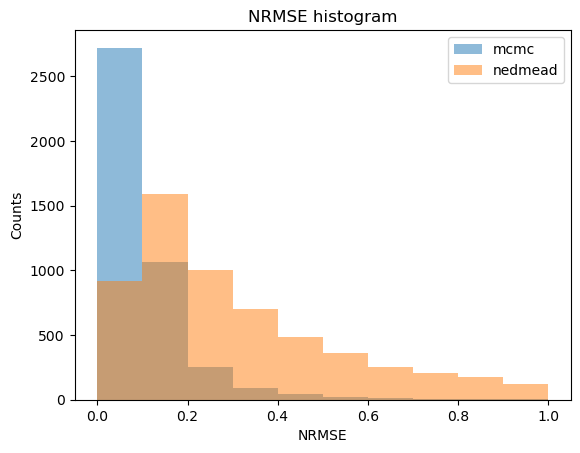

In [281]:
# histogram of different NRMSEs:
bins = np.linspace(0, 1, 11) 
plt.hist(mcmc_results['NRMSE'], bins=bins, alpha=0.5, label='mcmc')
plt.hist(nedmead_results['NRMSE'], bins=bins, alpha=0.5, label='nedmead')
plt.legend()
plt.title('NRMSE histogram')
plt.xlabel('NRMSE')
plt.ylabel('Counts')

Text(0, 0.5, 'Probability Density')

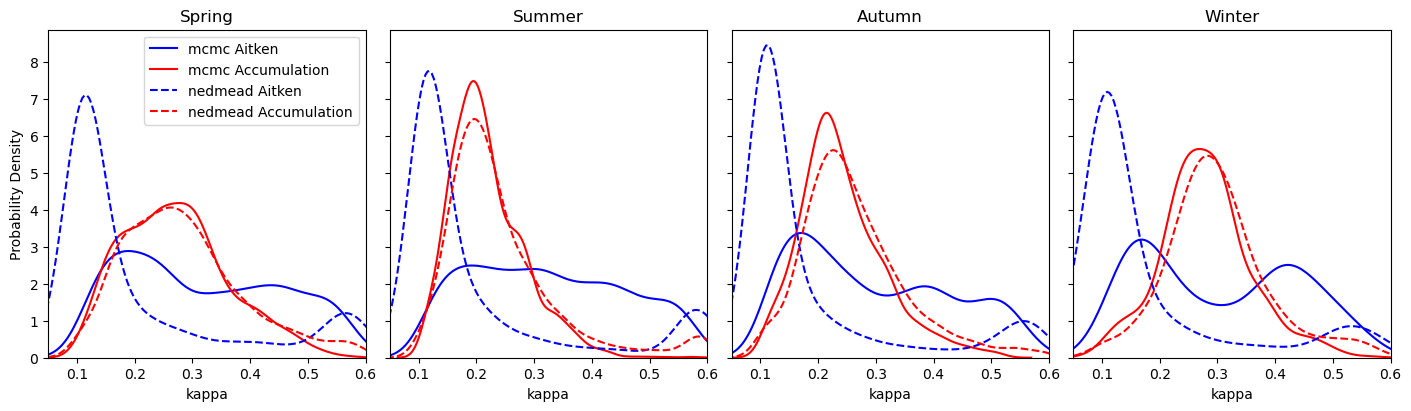

In [309]:
fig,axes = plt.subplots(ncols=4, nrows=1, figsize=(14,4), sharey=True, constrained_layout=True)

for season in range(4):
    ax = axes[season]

    # MCMC results
    group_mcmc = mcmc_results[mcmc_results['season'] == season]
    sns.kdeplot(group_mcmc['k1'].dropna(), ax=ax, label='mcmc Aitken', color='b', linewidth=1.5)
    sns.kdeplot(group_mcmc['k2'].dropna(), ax=ax, label='mcmc Accumulation', color='r', linewidth=1.5)

    # Nedmead results
    group_nedmead = nedmead_results[nedmead_results['season'] == season]
    sns.kdeplot(group_nedmead['k1'].dropna(), ax=ax, label='nedmead Aitken', color='b', linestyle='--', linewidth=1.5)
    sns.kdeplot(group_nedmead['k2'].dropna(), ax=ax, label='nedmead Accumulation', color='r', linestyle='--', linewidth=1.5)

    ax.set_title(['Spring', 'Summer', 'Autumn', 'Winter'][season])
    ax.set_xlim(0.05, 0.6)
    ax.set_xlabel('kappa')

axes[0].legend()
axes[0].set_ylabel('Probability Density')



In [282]:
4248/6580

0.6455927051671733